# Modulo de transmisor



En este apartado se resume el desarrollo del transmisor, el cual tiene la capacidad de capturar la informacion de latidos por minuto (bpm) que provienen de un monitor de ritmo cardiaco, los datos son tomados mediante un protocolo de comunicacion UART.

## Bloque Latidos por minuto/Prueba Ecostress


Este bloque tiene como objetivo modelar la adquisicion de datos entre el monitor cardiaco y el transmisor (TX)

In [ ]:
import pandas as pd
from scipy.stats import anderson

# Leer el archivo Excel
df = pd.read_excel('/content/Dataset.xlsx')
df1 = pd.read_excel('/content/Dataset_Crudo.xlsx')

# Extraer la columna relevante
data = df['BPM']
data2 = df1['BPM']

# Realizar la prueba de Anderson-Darling
result = anderson(data)

# Imprimir los resultados
print('p-value:', result[1])
print('Standard deviation:', data.std())
print('Average:', data.mean())

p-value: [0.559 0.637 0.764 0.891 1.06 ]
Standard deviation: 19.72707993812042
Average: 129.15458577437957


Los valores p obtenidos de la prueba de Anderson-Darling son mayores que 0.05 (niveles típicos de significancia). Esto sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de que los datos de latidos por minuto (bpm) siguen una distribución normal. Ademas, se tiene un promedio de 129.15 bpm y una desviación estándar de 19.73 bpm.

A continuación, se crea un histograma con los datos analizados.

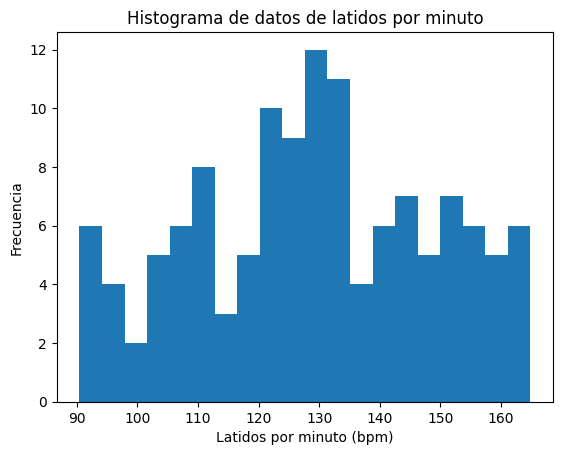

In [ ]:
# prompt: haz un histograma de los datos de excel
import matplotlib.pyplot as plt

plt.hist(data, bins=20)
plt.xlabel('Latidos por minuto (bpm)')
plt.ylabel('Frecuencia')
plt.title('Histograma de datos de latidos por minuto')
plt.show()


En el histograma anterior se puede apreciar que los datos muestran una distribucion de asimetría negativa.

Ahora, se crea una grafica de caja con el fin de identificar valores atipicos, ademas tambien se implementara el test de Grubbs.

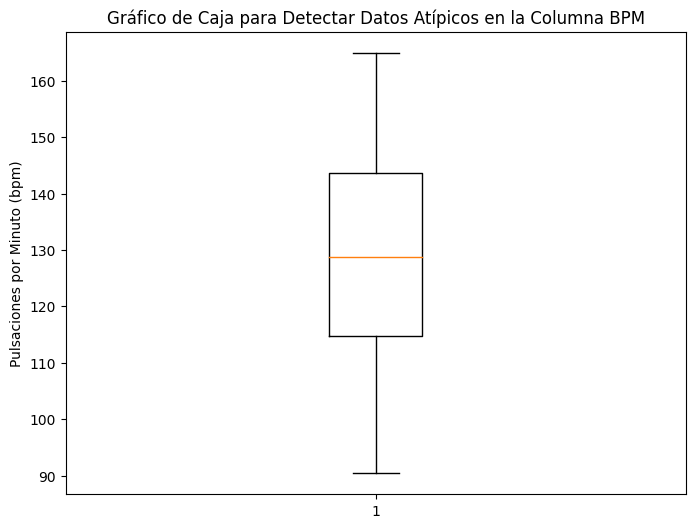

Valores atípicos identificados con el test de Grubbs:
[]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.stats import t
import numpy as np

# Especifica la ruta al archivo de Excel en tu Google Drive
ruta_archivo_excel = '/content/Dataset.xlsx'

# Lee el archivo de Excel en un DataFrame de Pandas
datos = pd.read_excel(ruta_archivo_excel, usecols=['BPM'])

# Genera el gráfico de caja (box plot)
plt.figure(figsize=(8, 6))
plt.boxplot(datos['BPM'])
plt.title('Gráfico de Caja para Detectar Datos Atípicos en la Columna BPM')
plt.ylabel('Pulsaciones por Minuto (bpm)')
plt.show()



def test_grubbs(data, alpha=0.05):
    """
    Test de Grubbs para identificar valores atípicos en un conjunto de datos univariado.

    Parámetros:
    data (array): Array de numpy que contiene los datos.
    alpha (float): Nivel de significancia para el test (valor por defecto es 0.05).

    Retorna:
    array: Array que contiene los valores atípicos identificados por el test de Grubbs.
    """
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    data_abs = np.abs(data - mean)
    max_index = np.argmax(data_abs)
    max_deviation = data_abs[max_index]
    critical_value = (n - 1) / np.sqrt(n) * np.sqrt(t.ppf(1 - alpha / (2 * n), n - 2) ** 2 / (n - 2 + t.ppf(1 - alpha / (2 * n), n - 2) ** 2))

    if max_deviation > critical_value * std_dev:
        return np.array([data[max_index]])
    else:
        return np.array([])

# Usar el test de Grubbs para identificar valores atípicos en la columna 'bpm'
valores_atipicos_grubbs = test_grubbs(datos['BPM'])

# Imprimir los valores atípicos identificados
print("Valores atípicos identificados con el test de Grubbs:")
print(valores_atipicos_grubbs)

Con respecto a los resultados anteriores se puede concluir que ningun valor atipico fue encontrado.


## Bloque procesamieto

En este apartado se procede a determinar el mejor tipo de filtrado para los datos que se estan manejando y para la aplicacion, cabe destacar, que el resultado debe ser el mas preciso posible, ya que, es una aplicación medica. Se tomaron en consideracion dos tipos de filtrados, se muestran a continuacion en la matriz trade-off.


| Criterio Técnico              | Media Móvil Simple (SMA) | Filtro de Kalman |
|-------------------------------|--------------------------|------------------|
| Facilidad de Implementación   | Alta                  | Baja          |
| Efectividad en la Filtración | Media                 | Alta          |
| Requerimientos de Recursos    | Bajos                 | Altos         |
| Adaptabilidad a Cambios       | Baja                  | Alta          |
| Complejidad de Entendimiento  | Baja                  | Alta          |




Se escogio el filtro SMA como posible solucion, a continuación, crea la implementacion y se compara con los datos sin filtrar para visualizar su efectividad y cual tipo de filtro funciona mejor.

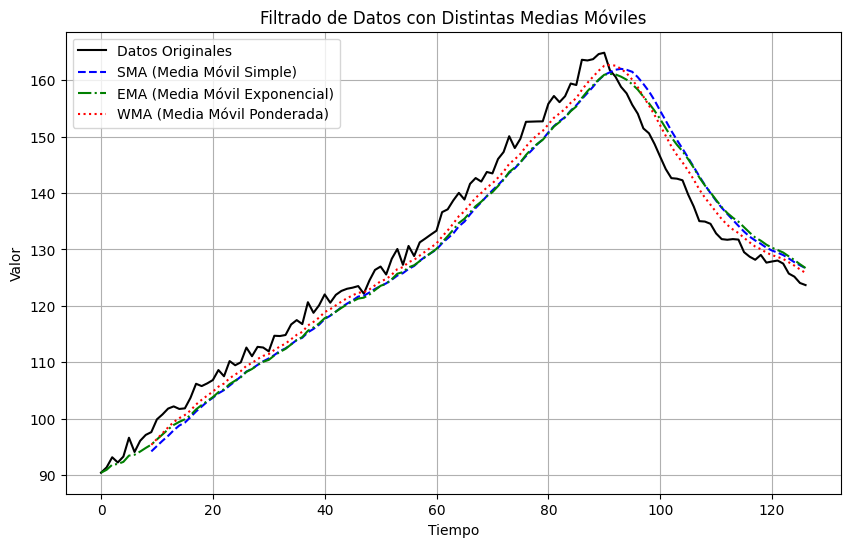

Tiempo promedio de filtrado para SMA: 0.0005447530746459961 segundos
Tiempo promedio de filtrado para EMA: 0.0004250061511993408 segundos
Tiempo promedio de filtrado para WMA: 0.001431751251220703 segundos


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Leer el archivo de Excel
ruta_archivo_excel = '/content/Dataset.xlsx'
datos = pd.read_excel(ruta_archivo_excel)

# Seleccionar la columna de interés
columna = 'BPM'
serie_temporal = datos[columna]

# Calcular las medias móviles
sma = serie_temporal.rolling(window=10).mean()  # SMA (Media Móvil Simple)
ema = serie_temporal.ewm(span=10).mean()        # EMA (Media Móvil Exponencial)
weights = np.arange(1, 11) / np.sum(np.arange(1, 11))
wma = serie_temporal.rolling(window=10).apply(lambda x: np.dot(x, weights), raw=True) # WMA (Media Móvil Ponderada)

# Graficar los datos originales y las medias móviles
plt.figure(figsize=(10, 6))
plt.plot(serie_temporal, label='Datos Originales', color='black')
plt.plot(sma, label='SMA (Media Móvil Simple)', linestyle='--', color='blue')
plt.plot(ema, label='EMA (Media Móvil Exponencial)', linestyle='-.', color='green')
plt.plot(wma, label='WMA (Media Móvil Ponderada)', linestyle=':', color='red')
plt.title('Filtrado de Datos con Distintas Medias Móviles')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


# Crear un DataFrame con las señales originales y filtradas
df = pd.DataFrame({ 'Datos Originales': serie_temporal, 'SMA': sma ,'EMA': ema, 'WMA': wma})

# Guardar el DataFrame en un archivo CSV para usarlo más tarde
df.to_csv('datos_guardados_Visual.csv', index=False)

#-------------------Tiempo de ejecucion de los filtros---------------------------------------------

def filter_signal(data, filter_type='sma', window_size=10, repetitions=200):
    """
    Función para filtrar una señal utilizando diferentes tipos de medias móviles y calcular el tiempo promedio.

    Parámetros:
    - data: Serie temporal de datos.
    - filter_type: Tipo de filtro a utilizar ('sma' para Media Móvil Simple, 'ema' para Media Móvil Exponencial, 'wma' para Media Móvil Ponderada). Por defecto, 'sma'.
    - window_size: Tamaño de la ventana para el filtro (solo aplica para SMA y WMA). Por defecto, 10.
    - repetitions: Número de repeticiones para calcular el tiempo promedio. Por defecto, 200.

    Retorna:
    - elapsed_time_avg: Tiempo promedio transcurrido durante el filtrado en segundos.
    """
    total_time = 0

    for _ in range(repetitions):
        start_time = time.time()

        if filter_type == 'sma':
            filtered_data = data.rolling(window=window_size).mean()
        elif filter_type == 'ema':
            filtered_data = data.ewm(span=window_size).mean()
        elif filter_type == 'wma':
            weights = np.arange(1, window_size + 1) / np.sum(np.arange(1, window_size + 1))
            filtered_data = data.rolling(window=window_size).apply(lambda x: np.dot(x, weights), raw=True)
        else:
            raise ValueError("Tipo de filtro no válido. Use 'sma', 'ema' o 'wma'.")

        elapsed_time = time.time() - start_time
        total_time += elapsed_time

    elapsed_time_avg = total_time / repetitions

    return elapsed_time_avg


# Calcular el tiempo promedio de filtrado para Media Móvil Simple (SMA)
sma_avg_time = filter_signal(datos, filter_type='sma')
print("Tiempo promedio de filtrado para SMA:", sma_avg_time, "segundos")

# Calcular el tiempo promedio de filtrado para Media Móvil Exponencial (EMA)
ema_avg_time = filter_signal(datos, filter_type='ema')
print("Tiempo promedio de filtrado para EMA:", ema_avg_time, "segundos")

# Calcular el tiempo promedio de filtrado para Media Móvil Ponderada (WMA)
wma_avg_time = filter_signal(datos, filter_type='wma')
print("Tiempo promedio de filtrado para WMA:", wma_avg_time, "segundos")


En los resultados del codigo anterior se puede apreciar como el metodo de WMA presenta una grafica mas cercana a la grafica original y los valores se ven bastantes suavizados, ademas el tiempo promedio de ejecucion del script que filtra los datos es de 661.88 micro segundos aproximandamente.

Para poder pasar el filtro seleccionado al SoC nRF52832 es necesario seguir un proceso metodologico que se explica a continuacion.

### Estrategia:

1. **Comprender el Código Python:**
   - Analizar y comprender completamente el filtro implementado en Python, incluyendo el algoritmo utilizado, las estructuras de datos involucradas y cualquier biblioteca externa utilizada.

2. **Revisar y Adaptar las Bibliotecas:**
   - Identificar las bibliotecas de Python utilizadas en el filtro y buscar alternativas en C++ que proporcionen funcionalidades similares.

3. **Transcribir el Código a C++:**
   - Transcribir el algoritmo del filtro a código C++. Asegurarse de mantener la lógica y la estructura del algoritmo, tener en cuenta las diferencias entre Python y C++, como la sintaxis, el manejo de tipos de datos y las funciones de biblioteca disponibles.

4. **Optimizar el Código:**
   - Optimizar el código C++ para el rendimiento y la eficiencia de memoria. .

5. **Pruebas y Depuración:**
   - Realizar pruebas exhaustivas en el código C++ para asegurarte de que funcione correctamente y produzca resultados similares a los del código Python original. Esto puede incluir pruebas unitarias, pruebas de integración y pruebas en el hardware objetivo (SoC nRF52832).

6. **Integración con el Proyecto del SoC nRF52832:**
   - Integrar el código del filtro C++ en el proyecto del SoC nRF52832, utilizando el SDK (Software Development Kit) y las herramientas de desarrollo proporcionadas por Nordic Semiconductor.

El SDK (software developtment kit) proporcionado por Nordic semiconductor provee un ambiente de desarrollo con ejemplos, bibliotecas, protocoloes, compilers y todo lo necesario para poder adaptar el codigo python al microcontrolador objetivo.

### DSPs en el SoC 2RF52832: Arquitectura y Ventaja como Coprocesador

#### Arquitectura de los DSPs:

Los DSPs (Procesadores de Señal Digital) pueden tener diferentes arquitecturas dependiendo del fabricante y del modelo específico. Sin embargo, la mayoría de los DSPs comparten algunas características comunes en su arquitectura:

1. **Pipeline Profundo:** Los DSPs suelen tener un pipeline profundo que permite la ejecución de múltiples instrucciones de manera simultánea y en paralelo.

2. **Unidades de Procesamiento Especializadas:** Están diseñados para realizar operaciones matemáticas y de procesamiento de señales de manera eficiente, con unidades de procesamiento especializadas.

3. **Memoria Especializada:** Integran memoria y periféricos específicos para el procesamiento de señales, como RAM y ROM optimizadas para estas operaciones.

4. **Instrucciones SIMD:** Muchos DSPs soportan instrucciones SIMD que permiten realizar operaciones en paralelo en múltiples datos simultáneamente.

#### Ventajas de usar DSPs como Coprocesador:

1. **Eficiencia en Procesamiento de Señales:** Están diseñados específicamente para aplicaciones de procesamiento de señales, lo que los hace altamente eficientes en este tipo de tareas.

2. **Rendimiento Optimizado:** La arquitectura especializada y el conjunto de instrucciones optimizado permiten un rendimiento superior en aplicaciones de procesamiento de señales.

3. **Bajo Consumo de Energía:** Están optimizados para operaciones con bajo consumo de energía.

4. **Programabilidad y Flexibilidad:** Aunque están diseñados para aplicaciones específicas, son programables y pueden adaptarse a una amplia gama de algoritmos y aplicaciones de procesamiento de señales.

5. **Integración con otros Componentes del Sistema:** Se integran fácilmente con otros componentes del sistema, permitiendo diseñar sistemas complejos y eficientes.

En resumen, los DSPs ofrecen una combinación única de rendimiento, eficiencia energética y flexibilidad que los hace ideales como coprocesadores para acelerar aplicaciones de procesamiento de señales en una variedad de dispositivos y sistemas.

## Bloque codificación

In [ ]:
import pandas as pd
import time

# Leer el archivo Excel
df = pd.read_excel('/content/Dataset.xlsx')

# Extraer la columna relevante
data = wma

# Codificación Hamming (7,4)
def hamming_encode_7_4(data):
    # Inicializar lista para almacenar los bits codificados
    encoded_data = []

    # Calcular bits de paridad
    p1 = (data[0] + data[1] + data[3]) % 2
    p2 = (data[0] + data[2] + data[3]) % 2
    p3 = (data[1] + data[2] + data[3]) % 2

    # Insertar bits de paridad y datos en la lista de datos codificados
    encoded_data.extend([p1, p2, data[0], p3, data[1], data[2], data[3]])

    return encoded_data
#Codificación Hamming (15,11)

def hamming_encode_15_11(data):
    # Inicializar lista para almacenar los bits codificados
    encoded_data = []

    # Calculando los bits de paridad (p1-p4)
    p1 = (data[0] + data[1] + data[3] + data[4] + data[6] + data[8] + data[10]) % 2
    p2 = (data[0] + data[2] + data[3] + data[5] + data[6] + data[9] + data[10]) % 2
    p3 = (data[1] + data[2] + data[3] + data[7] + data[8] + data[9] + data[10]) % 2
    p4 = (data[4] + data[5] + data[6] + data[7] + data[8] + data[9] + data[10]) % 2

    # Insertar bits de paridad y datos en la lista de datos codificados
    encoded_data.extend([p1, p2, data[0], p3, data[1], data[2], data[3], p4, data[4], data[5], data[6], data[7], data[8], data[9], data[10]])

    return encoded_data

def measure_hamming_encoding_time(data, encoding_function, repetitions=200):
    total_time = 0

    for _ in range(repetitions):
        start_time = time.time()

        # Aplicar la codificación de Hamming
        encoded_data = [encoding_function([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(4 if encoding_function == hamming_encode_7_4 else 11)]) for dato in data]
        elapsed_time = time.time() - start_time
        total_time += elapsed_time

    elapsed_time_avg = total_time / repetitions

    return elapsed_time_avg

# Medir el tiempo de codificación para Hamming (7,4)
hamming_avg_time_7_4 = measure_hamming_encoding_time(data, hamming_encode_7_4)
print("Tiempo promedio de codificación de Hamming (7,4):", hamming_avg_time_7_4, "segundos")

# Medir el tiempo de codificación para Hamming (15,11)
hamming_avg_time_15_11 = measure_hamming_encoding_time(data, hamming_encode_15_11)
print("Tiempo promedio de codificación de Hamming (15,11):", hamming_avg_time_15_11, "segundos")

# Codificar los datos BPM usando el código de Hamming (7,4)
datos_codificados_7_4 = [hamming_encode_7_4([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(4)]) for dato in data]

# Crear un DataFrame con los datos originales de BPM y los datos codificados
df_resultado_7_4 = pd.DataFrame({'BPM': data, 'BPM Codificado': datos_codificados_7_4})

# Codificar los datos BPM usando el código de Hamming (15,11)
datos_codificados_15_11 = [hamming_encode_15_11([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(11)]) for dato in data]
# Crear un DataFrame con los datos originales de BPM y los datos codificados
df_resultado_15_11 = pd.DataFrame({'BPM': data, 'BPM Codificado': datos_codificados_15_11})

# Imprimir los resultados
print ("Codificación con Hamming (7,4)")
print(df_resultado_7_4)
print ("Codificación con Hamming (15,11)")
print(df_resultado_15_11)

Tiempo promedio de codificación de Hamming (7,4): 0.0009792017936706542 segundos
Tiempo promedio de codificación de Hamming (15,11): 0.0013096904754638671 segundos
Codificación con Hamming (7,4)
            BPM         BPM Codificado
0           NaN  [0, 0, 0, 0, 0, 0, 0]
1           NaN  [0, 0, 0, 0, 0, 0, 0]
2           NaN  [0, 0, 0, 0, 0, 0, 0]
3           NaN  [0, 0, 0, 0, 0, 0, 0]
4           NaN  [0, 0, 0, 0, 0, 0, 0]
..          ...                    ...
122  128.315293  [1, 1, 1, 0, 0, 0, 0]
123  127.718945  [1, 1, 1, 1, 1, 1, 1]
124  127.134278  [1, 1, 1, 1, 1, 1, 1]
125  126.464762  [1, 1, 1, 1, 1, 1, 1]
126  125.826872  [1, 1, 1, 1, 1, 1, 1]

[127 rows x 2 columns]
Codificación con Hamming (15,11)
            BPM                                 BPM Codificado
0           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3           NaN  [0, 0, 0, 0

Con los resultados de la codificación con ambos tipos se realizó una comparación para ver las desventajas y las ventajas de cada uno.

|  Hamming (7,4)  |  Hamming (15,11)  |
|  -------------  |  ---------------  |
|  Agrega menos bits ya que agrega únicamente 3 a los 4 iniciales por lo que requiere un ancho de banda menor  |  Agrega más bits ya que a los 11 iniciales se les agrega 4 más por lo tanto necesita un ancho de banda mayor |  
|  Tiene una estructura más simple por lo que es más fácil de implementar y a su vez de entender  |  Tiene una estructura mucho más compleja por lo que es más difícil de implementar y de entender  |  
|  Tiene una menor capacidad para detectar y corregir errores esto ya que puede hacerlo solo con un error de bit  |  Es capaz de detectar y corregir errores en múltiples bits ya que tiene mayor número de bits de paridad  |
|  No es tan fiable ya que solo es capaz de corregir un error en un solo bit  |  Es más fiable ya que es capaz de detectar y corregir más errores  |
|  Tiene un tiempo de ejecución mucho más bajo  |  Tiene un tiempo de ejecución más alto  |

Por lo tanto según lo que se desee es mejor usar uno u otro ya que si se tiene un ancho de banda menor y la fiabilidad no debe ser muy alta es mejor el código (7,4) y si es más importante la fiabilidad que el ancho de banda que ocupa, y el tiempo que tarda en ejecutarse es mejor el código Hamming (15,11)

### Coprocesador DSP del SoC nRF52832 ventajas y desventajas con respectoa a la codificación

Se deben tomar ciertas cosas en consideración antes de tomar la decisión de si es mejor o si no el uso del coprocesador DSP para acelerar el proceso de la codificación estos aspectos son los siguientes:


- Rendimiento de cálculo: Los coprocesadores DSP están diseñados más específicamente para realizar operaciones matemáticas y aritméticas de una forma más eficiente, lo que puede mejorar el rendimiento almpararlo con la ejecución en el procesador principal. Si el proceso de codificación de Hamming involucra una gran cantidad de cálcuos, como operaciones de suma, multiplicación y comparación, es probable que un coprocesador DSP pueda acelerar el proceso.

- Disponibilidad y capacidad del coprocesador DSP: Es importante verificar si este coprocesador es capaz de ejecutar las operaciones necesarias para la codificación de Hamming de manera eficiente. Además de la capacidad de procesamiento del coprocesador DSP y la compatibilidad con las operaciones requeridas.

- Uso de recursos y energía: Se debe tamar en cuenta también el consumo de recursos y energía con el DSP en comparación con la ejecución en el procesador principal. Esto ya que es para garantizar que no se comprometan otros aspectos del sistema.

Por lo tanto dependiendo del código Hamming que se desee utilizar es mejor o no implementar este coprocesador, en el caso de que se escoja el hamming (7,4) no sería tan necesario ya que los cálculos involucrados son bastante simples por lo que no hace tanta falta ya que se puede ejecutar bien en el procesador principal, ahoora si se usa el hamming (15,11) este al ser mucho más grande y complejo si requiere operaciones matemáticas mucho más complejas por lo que para este si es necesario este coprocesador DSP ya que ayudaría en gran manera a aumentar el rendimiento, y en este caso como se dicutió anteriormente al ser datos médicos se prefiere la fiabilidad del hamming (15,11) por lo tanto si es mejor implementar el coprocesador.

##Bloque modulación


En esta parte del proyecto, se desarrolló un bloque que se encargue de aplicar el proceso de modulación utilizado por la tecnología BLE (Bluetooth Low Energy) a la información proveniente del bloque de Codificación. Este tipo de modulación es utilizada para aplicaciones de bajo consumo y con una baja tasa de transferencia de datos. La modulación que utilizda para BLE es la GFSK (Gaussian Frequency Shift Keying) la cual es una ligera variante con respecto a la FSK (Frequency Shift Keying), de forma que a esta ultima se le aplica un filtro gaussiano al cambio de frecuencia con la finalidad de suavizar las transisciones entre símbolos, teniendo como consecuencia un mejor aprovechamiento del ancho de banda a la vez que se mejora la resistencia a interferencias y atenuacines del canal. A continuacion se muestra el script desarrollado en Mathlab que muestra la modulación GFSK para ser utilizada en BLE, para este caso se utilizó una secuiancia de datos tomada de las obtenidas mediante la codificación de Hamming.

Tiempo de ejecución: 0.01844048500061035 segundos


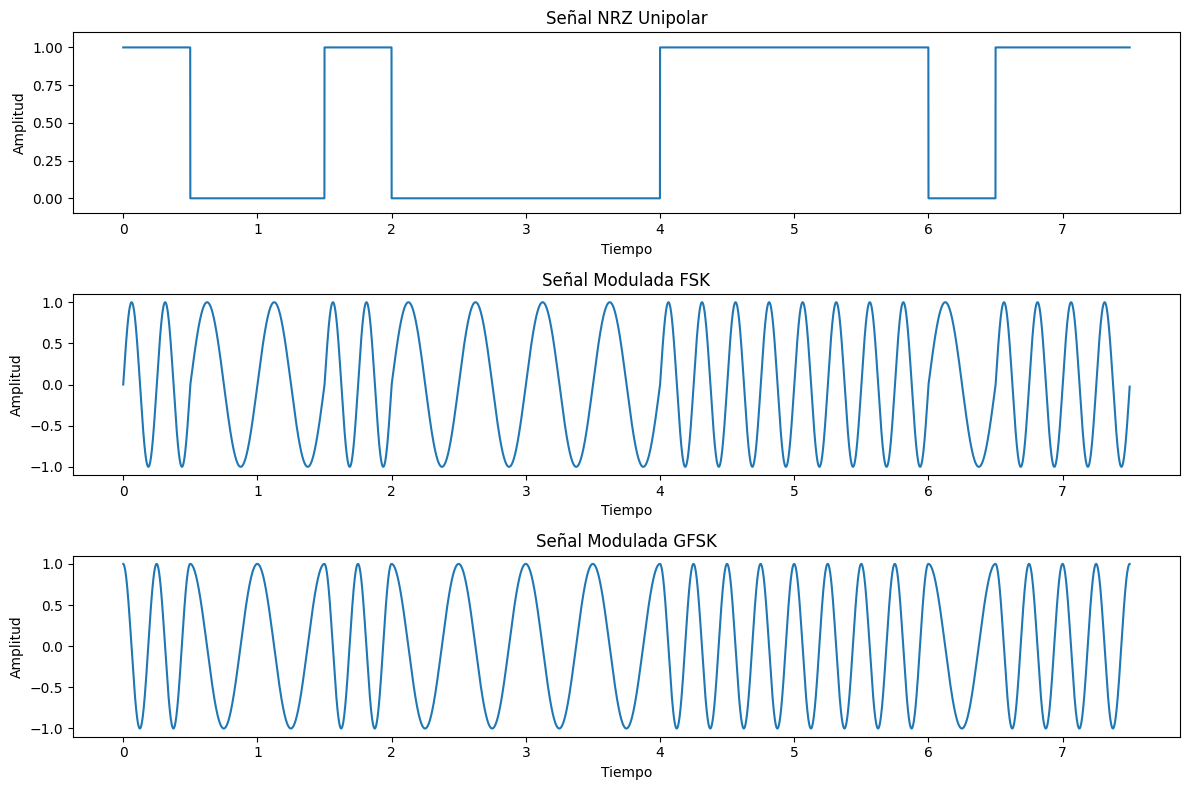

In [ ]:
# Secuencia de bits
bits = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]

# Parámetros de la señal
Tb = 0.5                # Duración de un bit
fs = 1000               # Frecuencia de muestreo
f0 = 2                  # Frecuencia de la portadora 0
f1 = 4                  # Frecuencia de la portadora 1
alpha = 0.5             # Factor de roll-off para GFSK

# Iniciar el contador de tiempo
start_time = time.time()

# Crear el tiempo de la señal
t = np.arange(0, len(bits) * Tb, 1 / fs)

# Generar señal NRZ unipolar
signal_NRZ = np.concatenate([
    np.ones(int(fs * Tb)) if bit == 1 else np.zeros(int(fs * Tb))
    for bit in bits
])

# Modulación FSK
signal_FSK = np.concatenate([
    np.sin(2 * np.pi * f1 * np.arange(0, Tb, 1 / fs)) if bit == 1 else np.sin(2 * np.pi * f0 * np.arange(0, Tb, 1 / fs))
    for bit in bits
])

# Modulación GFSK
signal_GFSK = np.concatenate([
    np.exp(1j * np.cumsum(2 * np.pi * (f1 if bit == 1 else f0) * np.ones(int(fs * Tb)) / fs)).real
    for bit in bits
])

# Detener el contador de tiempo y mostrar el tiempo de ejecución
print(f"Tiempo de ejecución: {time.time() - start_time} segundos")

# Graficar las señales
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, signal_NRZ)
plt.title('Señal NRZ Unipolar')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.ylim([-0.1, 1.1])

plt.subplot(3, 1, 2)
plt.plot(t, signal_FSK)
plt.title('Señal Modulada FSK')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(3, 1, 3)
plt.plot(t, signal_GFSK)
plt.title('Señal Modulada GFSK')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

En el script primeramente se definen variables necesarias como el tiempo de bit, frecuencia de muestreo, las frecuencias de las portadoras para cuando hay un 1 y para cuando hay un 0, además de un factor de roll-off para el filtro gaussiano. Además, se hace la conversión de la sucesión binaria a una señal binaria NRZ unipolar, la cual posteriormente se modulará para obtener la señal FSK, a la cual a la vez se aplica el filtro gaussiano para obtener finalmente esta señal suavizada denominada GFSK. Finalmente los resultados se pueden observar de la siguente forma:
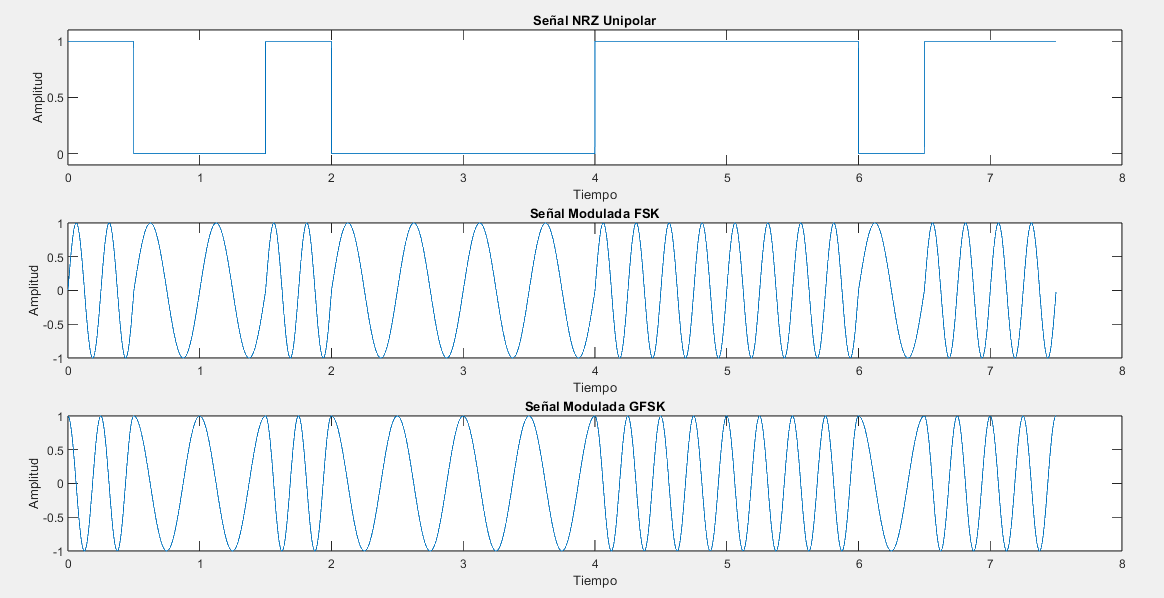

Finalmente como ultimo requisito se implemetó un contador de tiempo que permitiera observar en la terminal el tiempo de ejecucion del proceso de forma que se obtuvo el siguiente resultado:
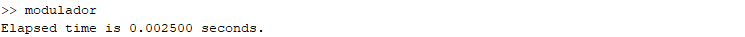

## Bloque antena

En este apartado se analizará los requerimientos correspondientes al desarrollo del bloque de la antena. Este bloque debe tener como función enviar el mensaje de información modulado hacia el receptor mediante un canal de comunicación.

La implementación del bloque Antena deberá ser basado sobre el PCB en Eagle proporcionado y la elección de una topología para la antena.

El PCB en cuestión está compuesto de dos capas (Top y Bottom), utiliza vías a través de agujero (through-hole vias) las cuales conectan las señales eléctricas entre las capas, las dimensiones de los pads, cables y demás.

Además, en el PCB hay un elemento llamado MM8130-2600 el cual es un componente diseñado para conectar dispositivos en aplicaciones de RF, operando en un rango de frecuencias de 0 Hz a 6 GHz y con una impedancia de 50 ohmios. Es comúnmente utilizado en conexiones de RF de alta frecuencia y está construido para montaje superficial.

En cuanto al desarrollo de la antena en Eagle, se debe considerar las bandas de funcionamiento de la tecnología BLE. Estas operan en un espectro que va de 2400 Hz a 2483.5 MHz, dividiéndose en 40 canales de 2 MHz de separación cada uno.

Mientras que las topologías que se considerarán son: Antena Monopolo en Forma de L y Antena Microstrip Circularmente Polarizada.

La Antena Monopolo en Forma de L tiene un patrón de radiación omnidireccional y se puede ajustar su resonancia variando la longitud y el ancho del conductor. Mientras que la Antena Microstrip Circularmente Polarizada ofrece una recepción mejorada debido a su capacidad de recibir señales de cualquier polarización, lo que es útil en aplicaciones móxiles donde la orientación del dispositivo es variable.

Para comparar estas topologías y decidir cuál es más adecuada para la implementación, se creó una matriz de trade-off:

| Métricas de Diseño                      | Antena Monopolo en Forma de L | Antena Microstrip Circularmente Polarizada |
|-----------------------------------------|-------------------------------|--------------------------------------------|
| Tamaño                                  | Pequeño                       | Grande                                     |
| Ancho de Banda                          | Estrecho                      | Amplio                                     |
| Eficiencia de Radiación                 | Moderada                      | Alta                                       |
| Complejidad de Diseño y Fabricación     | Baja                          | Alta                                       |
| Ganancia                                | Baja                          | Moderada a Alta                            |
| Costo                                   | Bajo                          | Moderado                                   |

Por lo tanto, la ventaja de la Antena Microstrip Circularmente Polarizada es que ofrece un ancho de banda más amplio y una mejor recepción de la señal debido a su capacidad para recibir señales de múltiples polarizaciones, sin embargo, suele ocupar más espacio en el PCB y puede ser más costosa y compleja de diseñar y fabricar. Mientras que la Antena Monopolo en Forma de L es más compacta, es más relativamente fácil de diseñar e integrar en un PCB con restricciones de espacio, sin embargo, la ganancia y el ancho de banda pueden estar limitados.

Por ende, considerando todos los aspectos anteriores se escogió la Antena Monopolo en Forma de L debido a que es menos sensible a las variaciones de la proximidad de otros componentes o capas del PCB, simplificando el diseño, e implica menos parámetros de ajuste críticos parra su diseño.

Los patrones de radiación de una antena monopolo en forma de L generalmente muestran un comportamiento omnidireccional en el plano horizontal (perpendicular al monopolo), lo que significa que la antena irradia energía de manera uniforme en todas las direcciones de ese plano. En el plano vertical (a lo largo del monopolo), el patrón tiende a ser más direccional, con menos radiación hacia arriba o hacia abajo directamente, debido a la presencia del plano de tierra. Este comportamiento se describe en "Antenna Theory: Analysis and Design" por Constantine A. Balanis.

En cuanto al software de simulación para antenas, los programas mencionados anteriormente como CST Studio Suite, ANSYS HFSS, y FEKO son adecuados para simular antenas monopolo. Estos programas permiten al usuario ingresar las dimensiones físicas y materiales de la antena y del entorno circundante para calcular el patrón de radiación, la impedancia de entrada y otros parámetros importantes.


#### Importancia del Plano a Tierra
El plano a tierra es crucial en el diseño de antenas por varias razones. Primero, actúa como un reflector que ayuda a dirigir la radiación hacia adelante, mejorando así la eficiencia de la antena. También ayuda a establecer una impedancia de entrada predecible y mejora el ancho de banda de la antena. Además, el plano a tierra minimiza las interferencias y el acoplamiento entre la antena y otros componentes del circuito. En el diseño de PCBs para RF, la implementación adecuada del plano a tierra es esencial para el rendimiento óptimo del sistema de comunicación.


#### Interpretación de las Mediciones del Parámetro S11
El parámetro S11 o coeficiente de reflexión indica cuánta de la potencia enviada a la antena es reflejada de vuelta debido a desajustes de impedancia. Un valor ideal de S11 en la frecuencia de operación de la antena sería de -10 dB o menos, lo que indica que la mayor parte de la potencia es aceptada por la antena y no reflejada. Las mediciones del S11 se realizan con un analizador vectorial de redes (VNA), y una curva típica mostraría un mínimo profundo en la frecuencia de resonancia, evidenciando una buena adaptación de impedancia.


#### Implicaciones de Sustratos Flexibles en el Patrón de Radiación
1. Variación de la Impedancia de la Antena: El uso de sustratos flexibles puede llevar a variaciones en la impedancia de entrada de la antena debido a las deformaciones físicas.

2. Desviación del Patrón de Radiación: La flexión del sustrato puede causar desviaciones en el patrón de radiación esperado. En antenas con sustratos flexibles, el patrón puede variar dependiendo del grado y la dirección de la flexión. Esto podría ser especialmente relevante en aplicaciones donde la orientación precisa del patrón de radiación es crítica.

3. Efectos sobre la Ganancia y la Direccionalidad: La ganancia y la direccionalidad de la antena también pueden verse afectadas por el uso de sustratos flexibles. La deformación del sustrato puede conducir a una distribución no uniforme de los campos electromagnéticos, lo que potencialmente reduce la ganancia y altera la direccionalidad de la antena.

Por otra parte, la elección del sustrato para el desarrollo de antenas microstrip tiene un impacto significativo en sus propiedades de rendimiento, especialmente en aplicaciones de alta frecuencia como la tecnología BLE. Los sustratos más comunes son FR-4 y Rogers Materials, cada uno con sus características distintivas.

1. Constante Dieléctrica (εr): FR-4 generalmente tiene una constante dieléctrica en el rango de 4.0 a 4.5 mientras que Rogers Materials ofrece una gama de constantes dieléctricas, muchas de las cuales son más bajas que las de FR-4, permitiendo una miniaturización de la antena.

2. Pérdida Dieléctrica (Tan δ): FR-4 posee un factor de pérdida dieléctrica relativamente alto, lo que puede no ser ideal para aplicaciones de alta frecuencia debido a una mayor atenuación de la señal. Mientras que Rogers Materials presenta bajos factores de pérdida dieléctrica, lo que se traduce en un mejor rendimiento para señales de alta frecuencia al minimizar la atenuación.

3. Estabilidad Térmica: FR-4 puede experimentar variaciones en su constante dieléctrica con cambios de temperatura, afectando la consistencia del rendimiento de la antena. Mientras que Rogers Materials ofrece una mejor estabilidad térmica, con variaciones mínimas en la constante dieléctrica y el factor de pérdida a lo largo de un amplio rango de temperaturas.

4. Costo: FR-4 es considerablemente más económico que los materiales especializados mientras que Rogers Materials tienden a ser más costosos.


#### Elección de Sustrato para Tecnología BLE

Para aplicaciones BLE, que operan en la banda de 2.4 GHz, la elección entre FR-4 y Rogers dependerá de varios factores:

1. Costo vs. Rendimiento: Si el presupuesto es limitado y el rendimiento deseado está dentro de las capacidades del FR-4, este puede ser suficiente. Sin embargo, para aplicaciones de alta gama donde el rendimiento y la fiabilidad de la señal son críticos, Rogers puede ser la mejor elección.
2. Tamaño de la Antena: Para diseños que requieren miniaturización o están restringidos por espacio, Rogers con su menor constante dieléctrica permite antenas más pequeñas.
3. Estabilidad Ambiental: En ambientes con variaciones significativas de temperatura o para dispositivos que requieren una precisión constante, Rogers ofrece una mejor estabilidad térmica.


#Requerimiento del canal

Este bloque tiene como función principal modelar de una manera aproximada el canal de comunicación entre el transmisor y el receptor, esto se debe a que no se cuenta con un modelo preestablecido del canal.


##Bloque del canal

### Analisis del código de modelado de un canal AWGN

El codigo en C del enlace proporcionado implementa una función en C para generar muestras de ruido blanco gaussiano aditivo utilizando el método de transformación inversa de la distribución normal estándar. Utiliza la función rand() para generar números aleatorios y la función cos() para calcular valores coseno.

Para el codigo en C proporcionado este de igual forma genera ruido blanco gaussiano (AWGN) pero en este caso usando la transformación box-muller, además, muestra la frecuencia de ocurrencia del ruido en diferentes intervalos y provee un archivo para ser representado graficamente.

### Transformada Box-Muller

La transformada Box-Muller es un procedimiento utilizado para obtener pares de números aleatorios independientes que siguen una distribución normal estándar (media cero y varianza uno), utilizando como entrada una fuente de números aleatorios distribuidos. Este método, desarrollado por George Edward Pelham Box y Mervin Edgar Muller, permite generar muestras de una distribución normal a partir de muestras uniformemente distribuidas en un intervalo específico.

A continuación, se procede a mostrar el codigo de modelado del canal con ruido AWGN:

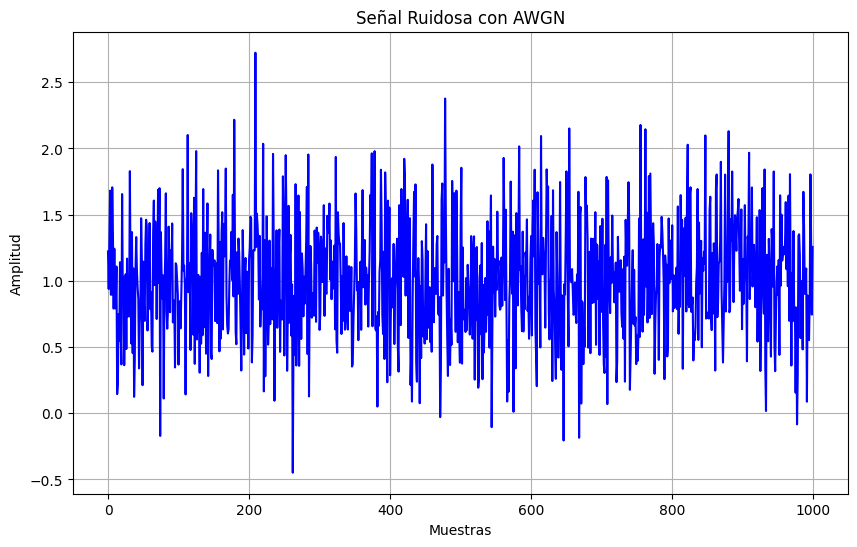

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def awgn_channel(signal_power, noise_power, num_samples):
    # Genera la señal ruidosa utilizando el método de Box-Muller
    noise_std = np.sqrt(noise_power)
    noise = noise_std * np.random.randn(num_samples)
    noisy_signal = signal_power + noise
    return noisy_signal

def main():
    # Parámetros del canal
    signal_power = 1.0  # Potencia de la señal
    noise_power = 0.2  # Potencia del ruido
    num_samples = 1000  # Número de muestras

    # Configuración de la semilla para reproducibilidad
    np.random.seed(42)

    # Genera la señal ruidosa utilizando el canal AWGN
    noisy_signal = awgn_channel(signal_power, noise_power, num_samples)

    # Grafica la señal ruidosa
    plt.figure(figsize=(10, 6))
    plt.plot(noisy_signal, color='blue')
    plt.title('Señal Ruidosa con AWGN')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()



### Fading en señales de comunicación y afectación en tecnologia BLE.

El fading en señales de comunicación se refiere a la atenuación o variación aleatoria de la amplitud, fase o tiempo de la señal en el momento que se esta propagando sobre el tiempo y la distancia, esto es causa de las condiciones atmosféricas y de propagacion, asi como obstaculos en el entorno de transmisión.

Bluetooth Low Energy (BLE) es una tecnología que se basa en la transmisión de datos de forma inalámbrica, por lo que si se trata de una aplicación médica, el funcionamiento del dicha tecnología debe ser muy buena, sin embargo, como el mundo no es ideal existirán varios factores que pueden bajar el rendimiento de la transmisión de datos lo que provocaría degradación de la señal, más probabilidad de errores en la transmisión y disminución del alcance.


### Efecto multicamino en la tecnologia BLE.
El efecto multicamino consiste en las señales de radio alcanzando la antenta mediante uno o más caminos. Causas del efecto multicamino son los conductos atmosféricos, reflexión y refracción ionosférica, y reflexion de cuerpos de agua y objetos terrestres como montañas y edificion.

Cuando la misma señal es recibida a través de más de un camino se puede producir interferencia porque además las señales llegan a su destino desfasadas por lo que podrian causar interferencia destructiva provocando que la señal sea débil en ciertas áreas.

Una posible solucion a este problema es la implementación de diversidad espacial, es decir, usar múltiples antenas receptoras, sin embargo, esto aumentaria el costo, por lo que otra aproximación sería la diversidad en el tiempo, por lo que se tendría que enviar la misma información en diferentes ranuras de tiempo, manteniendo de esta forma la cantidad de receptores necesarios sin aumentar el costo.

### Capacidad del canal y relacion de velocidad de transferencia de datos del SoC nRF52832

Para determinar la capacidad del canal se usa la siguieten ecuación:

$C = B\log_2(1 + \frac{S}{N})$

Donde los parametros tienen el siguiente significado:

- C es la capacidad del canal en bits por segundo (bps).
- B es el ancho de banda del canal en hertz (Hz).
- S es la potencia de la señal.
- N es la potencia del ruido.
- $\frac{S}{N}$ es la relacion señal-ruido (SNR).

El nRF52832 usa un ancho de banda de 1MHz por el canal en modo BLE, ademas, asumiendo que se esta transmitiendo en un entorno si ruido se tiene que:

$SNR_{dB}=20$<br>
$SNR=100$

Realizando el calculo se tiene el siguiente resultado:

$C = 1x10e6\log_2(1+100)=6.66Mbps$

Tomando el cuenta el resultado anterior y que para BLE 4.2 se tiene una transferencia de 1Mbps y para BLE 5.0 de 2Mbps se puede sugerir que bajo condiciones ideales con un SNR de 20dB, el canal no se saturaría con las tasas de datos máximas que soportal el SoC, ya que la capacidad del canal es suficiente para manejar estas tasas.

### Cambio en terminos del SNR y jitter en el diagrama de ojo si se pudieran hacer transferencias de datos en alta velocidad

Un alto SNR (relación señal/ruido) resulta en un diagrama de ojo más abierto verticalmente, mientras que un bajo SNR provoca el cierre del diagrama de ojo en la misma dirección. De manera similar, un alto jitter ocasiona un cierre horizontal del diagrama de ojo, mientras que un bajo jitter tiene el efecto contrario. Estas condiciones complican la muestreo de la señal en términos de potencia y temporización. Por lo tanto, para lograr una transferencia de datos a alta velocidad, es crucial gestionar de manera eficiente los tiempos de muestreo y la potencia de la señal transmitida. Posiblemente con una transferencia de alta velocidad se pueden presentar problemas de tiempo y potencia, la mejora de este aspecto depende del hardware implementado y las tecnicas de codificación.





# Requerimiento para el módulo Receptor (RX)

## Bloque demodulador


Para la seccion de la demodulación se utilizó nuevamente la seccion de código utilizada en la moudulación para obtener la señal modulada y a partir de ahi, realizar el proceso de demodulación de la señal GFSK en el receptor, de forma que nos permita obtener nuevamente la señal binaria NRZ unipolar,para finalmente proceder a la decodificación y obtener la trama de bits original que vue enviada por el transmisor.

Trama de bits obtenida en el receptor:
[0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


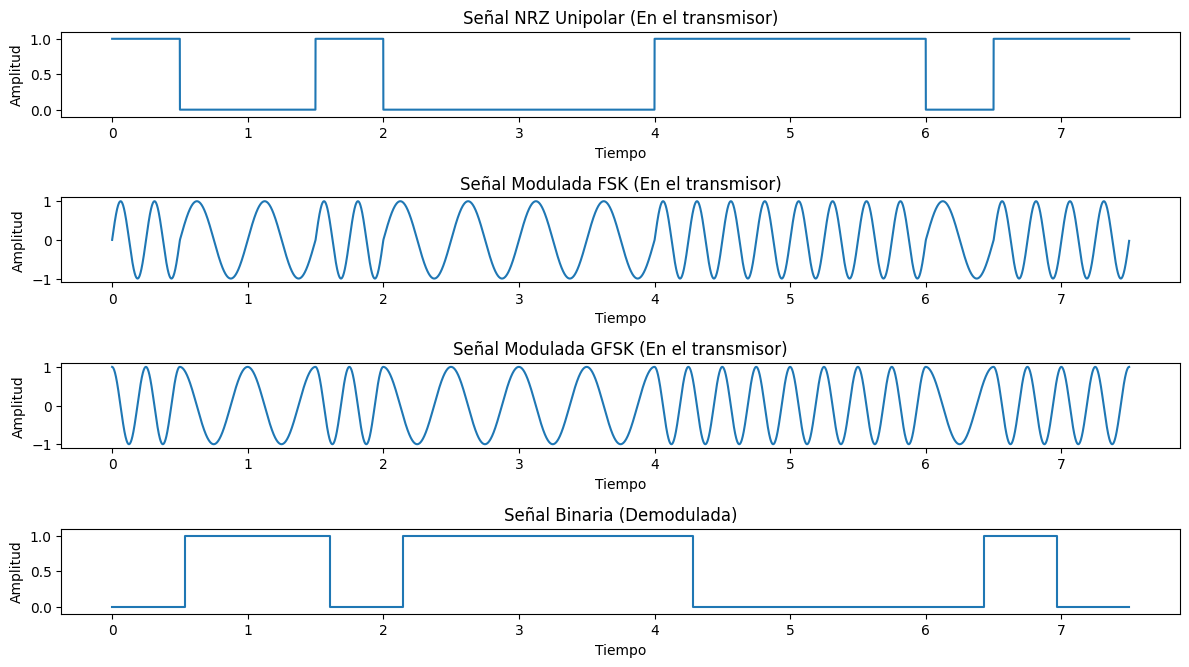

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Secuencia de bits
bits = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]

# Parámetros de la señal
Tb = 0.5               # Duración de un bit
fs = 1000              # Frecuencia de muestreo
f0 = 2                 # Frecuencia de la portadora 0
f1 = 4                 # Frecuencia de la portadora 1

# Crear el tiempo de la señal
t = np.arange(0, len(bits) * Tb, 1 / fs)

# Generar señal NRZ unipolar
signal_NRZ = np.concatenate([
    np.ones(int(fs * Tb)) if bit == 1 else np.zeros(int(fs * Tb))
    for bit in bits
])

# Modulación FSK
signal_FSK = np.concatenate([
    np.sin(2 * np.pi * f1 * np.arange(0, Tb, 1 / fs)) if bit == 1 else np.sin(2 * np.pi * f0 * np.arange(0, Tb, 1 / fs))
    for bit in bits
])

# Modulación GFSK
signal_GFSK = np.concatenate([
    np.exp(1j * np.cumsum(2 * np.pi * (f1 if bit == 1 else f0) * np.ones(int(fs * Tb)) / fs)).real
    for bit in bits
])

# Graficar las señales
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.plot(t, signal_NRZ)
plt.title('Señal NRZ Unipolar (En el transmisor)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.ylim([-0.1, 1.1])

plt.subplot(5, 1, 2)
plt.plot(t, signal_FSK)
plt.title('Señal Modulada FSK (En el transmisor)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

plt.subplot(5, 1, 3)
plt.plot(t, signal_GFSK)
plt.title('Señal Modulada GFSK (En el transmisor)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')

# Demodulación GFSK en el receptor
threshold = (f0 + f1) / 2  # Umbral para comparar energías
received_bits_GFSK = np.zeros(len(bits))

for i in range(len(bits)):
    # Calcular la energía en la frecuencia f0
    segment = signal_GFSK[int(i*fs*Tb):int((i+1)*fs*Tb)]
    t_segment = np.arange(0, Tb, 1 / fs)
    energy_f0 = np.sum(segment * np.sin(2 * np.pi * f0 * t_segment)) / (fs * Tb)
    # Calcular la energía en la frecuencia f1
    energy_f1 = np.sum(segment * np.sin(2 * np.pi * f1 * t_segment)) / (fs * Tb)

    # Comparar las energías
    if energy_f1 > energy_f0:
        received_bits_GFSK[i] = 1
    else:
        received_bits_GFSK[i] = 0

# Crear el vector de tiempo discreto para la secuencia de bits demodulada
t_bits = np.linspace(0, len(bits) * Tb, len(bits))

# Graficar la señal binaria (Demodulada)
plt.subplot(5, 1, 4)
plt.step(t_bits, received_bits_GFSK, where='post')
plt.title('Señal Binaria (Demodulada)')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.ylim([-0.1, 1.1])

# Imprimir la trama de bits obtenida en el receptor
print('Trama de bits obtenida en el receptor:')
print(received_bits_GFSK.astype(int))

plt.tight_layout()
plt.show()


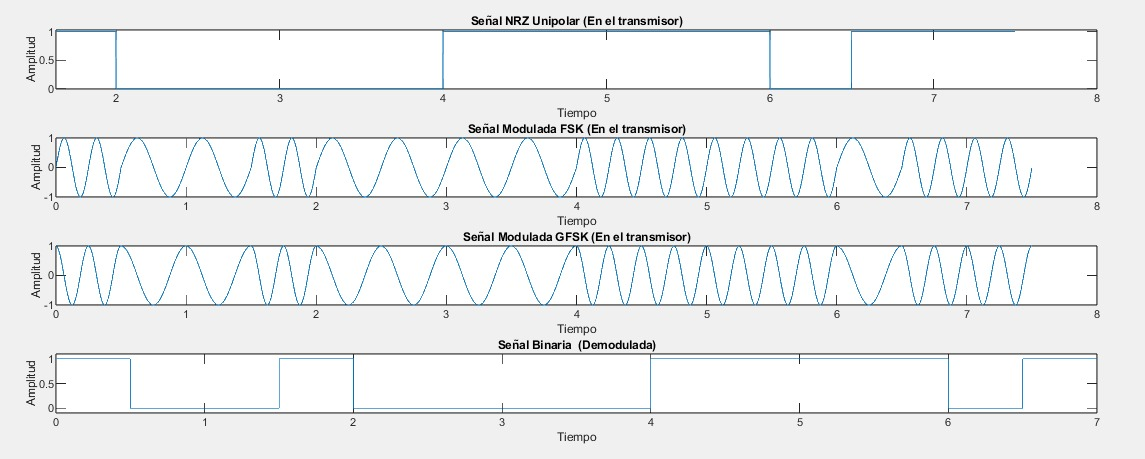


Se puede denotar que hay una consistencia en las señales, además se imprimió la trama de bits en el receptor para compararla con la trama de bits transmitida y se obtuvo el resultado correcto como se observa a continuación :
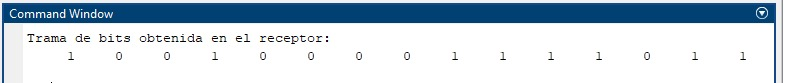

Finalmente como ultimo requisito se implemetó un contador de tiempo que permitiera observar en la terminal el tiempo de ejecucion del proceso de forma que se obtuvo el siguiente resultado:
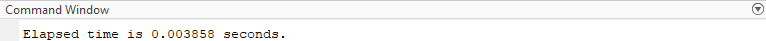

## Bloque decodificador

In [ ]:
import numpy as np
import time

def add_noise(encoded_data, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    noisy_data = []
    for block in encoded_data:
        noisy_block = np.copy(block)
        noise = np.random.normal(0, noise_std, len(block))
        noisy_block = (noisy_block + noise).astype(int) % 2
        noisy_data.append(noisy_block)
    return noisy_data

def decode_hamming_74(encoded_data):
    decoded_data = []
    error_count = 0

    for block in encoded_data:
        # Calcula los bits de paridad
        p1 = (block[0] + block[1] + block[3]) % 2
        p2 = (block[0] + block[2] + block[3]) % 2
        p3 = (block[1] + block[2] + block[3]) % 2

        # Calcula el índice del bit erróneo
        error_index = p1 + p2 * 2 + p3 * 4

        # Corrige el bit erróneo
        corrected_block = list(block)
        if error_index != 0:
            corrected_block[error_index - 1] = corrected_block[error_index - 1] ^ 1
            error_count += 1

        # Descarta los bits de paridad y agrega los datos decodificados a la lista
        decoded_data.extend(corrected_block[3:])

    return decoded_data, error_count

def decode_hamming_1511(encoded_data):
    decoded_data = []
    error_count = 0

    for block in encoded_data:
        # Calcula los bits de paridad
        p1 = (block[0] + block[1] + block[3] + block[4] + block[6] + block[8] + block[10] + block[11] + block[13]) % 2
        p2 = (block[0] + block[2] + block[3] + block[5] + block[6] + block[9] + block[10] + block[12] + block[13]) % 2
        p3 = (block[1] + block[2] + block[3] + block[7] + block[8] + block[9] + block[10] + block[14]) % 2

        # Calcula el índice del bit erróneo
        error_index = p1 + p2 * 2 + p3 * 4

        # Corrige el bit erróneo
        corrected_block = list(block)
        if error_index != 0:
            corrected_block[error_index - 1] = corrected_block[error_index - 1] ^ 1
            error_count += 1

        # Descarta los bits de paridad y agrega los datos decodificados a la lista
        decoded_data.extend(corrected_block[3:])

    return decoded_data, error_count

def calculate_ber(original_data, decoded_data):
    errors = sum(o != d for o, d in zip(original_data, decoded_data))
    return errors / len(original_data)

# Datos codificados en Hamming (7,4) y (15,11)
datos_codificados_7_4 = datos_codificados_7_4
datos_codificados_15_11 = datos_codificados_15_11

# SNR del canal
snr_db = 20

# Agrega ruido a los datos codificados
datos_ruidosos_7_4 = add_noise(datos_codificados_7_4, snr_db)
datos_ruidosos_15_11 = add_noise(datos_codificados_15_11, snr_db)

# Medir el tiempo de ejecución para la decodificación Hamming (7,4)
start_time_74 = time.time()
decoded_data_7_4, error_count_7_4 = decode_hamming_74(datos_ruidosos_7_4)
end_time_74 = time.time()
execution_time_74 = end_time_74 - start_time_74

# Medir el tiempo de ejecución para la decodificación Hamming (15,11)
start_time_1511 = time.time()
decoded_data_15_11, error_count_15_11 = decode_hamming_1511(datos_ruidosos_15_11)
end_time_1511 = time.time()
execution_time_1511 = end_time_1511 - start_time_1511

# Cálculo del BER
ber_7_4 = calculate_ber([bit for block in datos_codificados_7_4 for bit in block[3:]], decoded_data_7_4)
ber_15_11 = calculate_ber([bit for block in datos_codificados_15_11 for bit in block[3:]], decoded_data_15_11)

# Agrupación de los datos decodificados en grupos de 4 (Hamming 7,4) y 11 (Hamming 15,11)
decoded_data_grouped_7_4 = [decoded_data_7_4[i:i+4] for i in range(0, len(decoded_data_7_4), 4)]
decoded_data_grouped_15_11 = [decoded_data_15_11[i:i+11] for i in range(0, len(decoded_data_15_11), 11)]

# Impresión de los datos decodificados
print("Datos decodificados (Hamming 7,4):")
for group in decoded_data_grouped_7_4:
    print(group)


print("\nDatos decodificados (Hamming 15,11):")
for group in decoded_data_grouped_15_11:
    print(group)

# Impresión del tiempo de ejecución
print(f"\nTiempo de ejecución para Hamming (7,4): {execution_time_74:.6f} segundos")
print(f"Tiempo de ejecución para Hamming (15,11): {execution_time_1511:.6f} segundos")

# Guardar resultados en un archivo de texto plano
with open('resultados_hamming.txt', 'w') as file:
    file.write(f"Resultados de la decodificación Hamming (7,4):\n")
    file.write(f"Errores corregidos: {error_count_7_4}\n")
    file.write(f"BER: {ber_7_4:.6f}\n")
    file.write(f"Tiempo de ejecución: {execution_time_74:.6f} segundos\n\n")
    file.write(f"Resultados de la decodificación Hamming (15,11):\n")
    file.write(f"Errores corregidos: {error_count_15_11}\n")
    file.write(f"BER: {ber_15_11:.6f}\n")
    file.write(f"Tiempo de ejecución: {execution_time_1511:.6f} segundos\n")






Datos decodificados (Hamming 7,4):
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[1, 1, 0, 1]
[0, 1, 0, 1]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 1, 0, 1]
[0, 1, 1, 1]
[0, 1, 0, 1]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 1, 1, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 1, 0]
[1, 1, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[1, 0, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 1, 0, 1]
[1, 0, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
[1,

# Desempeño de los Enfoques de Hamming (7,4) y Hamming (15,11)

## Ganancia de Código

La ganancia de código es una medida de la mejora en la relación señal a ruido (SNR) que se obtiene al usar un código de corrección de errores en comparación con no usar ningún código. Se calcula como:

$Ganancia_de_código  = 10\log_{10} (\frac{Tasa-de-información}{Tasa-de-codificación})$


Para Hamming (7,4), la tasa de información es 4/7 , y para Hamming (15,11), es 11/15. Dado que la proporción de bits de información en Hamming (15,11) es mayor, este código ofrece una mejor ganancia de código.

## Ventajas y Desventajas

### Hamming (7,4)

Ventajas:
 1. Menos complejidad en la implementación debido a la longitud más corta de la palabra.
 2. Procesamiento más rápido debido a la menor longitud de la palabra.
 3. Efectivo en entornos donde los errores son poco frecuentes.

Desventajas:}
 1. Solo puede corregir un solo bit por palabra de 7 bits.
 2. Proporción menor de bits de datos útiles en comparación con Hamming (15,11).

### Hamming (15,11)

Ventajas:
 1. Puede corregir más errores de un solo bit que Hamming (7,4).
 2. Proporción más alta de bits de datos útiles, mejorando la eficiencia en la transmisión de datos.
 3. Proporción mejorada de bits de datos a bits de control.

Desventajas:}
 1. Implementación más compleja debido a la mayor longitud de la palabra.
 2. Procesamiento más lento debido a la mayor longitud de la palabra.
 3. Requiere más memoria y capacidad de procesamiento.


En conclusión la elección entre Hamming (7,4) y Hamming (15,11) depende del balance entre la complejidad del sistema y la necesidad de corrección de errores. Hamming (15,11) es preferible en sistemas donde la eficiencia y la capacidad de corrección son cruciales. En sistemas más simples y con menos ruido, Hamming (7,4) puede ser suficiente y más fácil de implementar. Más sin embargo como en este caso es aplicado a la medicina es mucho más importante tener los resultados más precisos posibles, por lo tanto es mejor Hamming (15,11)

# Análisis de CRC vs. Hamming en Tecnología BLE


## CRC (Cyclic Redundancy Check)

**Ventajas:**
- **Detección de Errores Eficiente:** CRC es muy eficiente en la detección de errores, especialmente los errores de ráfaga (burst errors), que son comunes en los canales de comunicación.
- **Rapidez:** La implementación de CRC es rápida y consume menos recursos, lo que es ideal para dispositivos con limitaciones de energía y procesamiento, como los dispositivos BLE.
- **Simplicidad:** CRC es más sencillo de implementar y no requiere un algoritmo complejo para su funcionamiento.

**Desventajas:**
- **No Corrige Errores:** CRC solo detecta errores, pero no los corrige. Esto significa que los paquetes de datos con errores deben ser retransmitidos, lo que puede incrementar la latencia y el uso de ancho de banda.
- **Dependencia de la Retransmisión:** En un entorno con mucho ruido, la necesidad de retransmisiones puede afectar el rendimiento general del sistema.

## Código Hamming

**Ventajas:**
- **Corrección de Errores:** Hamming no solo detecta, sino que también corrige errores de un solo bit, lo cual puede reducir la necesidad de retransmisión y mejorar la eficiencia del sistema.
- **Eficiencia en Canales Ruidosos:** En entornos con ruido, Hamming puede mejorar la integridad de los datos al corregir errores en el mismo paquete de datos.

**Desventajas:**
- **Mayor Complejidad:** La implementación de Hamming es más compleja y consume más recursos en términos de procesamiento y memoria, lo cual puede ser un desafío para dispositivos con restricciones como los dispositivos BLE.
- **Menor Eficiencia en Errores de Ráfaga:** Hamming es menos eficiente que CRC en la detección y corrección de errores de ráfaga, que pueden afectar múltiples bits consecutivos.
- **Mayor Overhead:** La inclusión de bits de paridad adicionales aumenta el tamaño del paquete de datos, lo que puede reducir la eficiencia de la transmisión.


En conclusión la elección entre CRC y Hamming depende del balance entre la necesidad de detección y corrección de errores y las limitaciones del dispositivo y del entorno de comunicación. CRC es preferible en escenarios donde la detección rápida y eficiente de errores es crítica y los recursos son limitados, como en la mayoría de los dispositivos BLE. Hamming puede ser más adecuado en sistemas donde la corrección de errores en el propio paquete de datos es más importante y los recursos de procesamiento y memoria son menos restringidos.






## Bloque visualización

En esta sección se utilizó la información recibida por el decodificador de tal manera que se pudieron representar de una manera visual mediante gráficos elaborados mediante Python, para la gráfica de las zonas de entrenamiento, donde se tienen las distintas zonas de entrenamiento diferenciadas por con su respectivo nombre y un color, además se muestra un gráfico que presenta los de latidos por minuto tanto para los datos originales como los que fueron obtenidos con la Filtración SMA y finalmente se muestra el gráfico del BER tanto para hamming (7,4) y (15,11) respectivamente.
Adicionalmente estos gráficos se guradan en un archivo PDF.

In [ ]:
pip install matplotlib seaborn fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=62d26a30bc0d0537e7002436575004952873b90bc38f1c011ae0fb50c424f14c
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fpdf import FPDF
import pandas as pd
import time

# Función para crear las gráficas y exportarlas a PDF
def create_and_save_plots():
    start_time = time.time()  # Registro del tiempo de inicio

    # Cargar los datos filtrados desde el archivo CSV
    df = pd.read_csv('datos_guardados_Visual.csv')

    # Zonas de entrenamiento
    # Graficar las señales y las zonas de entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(df['SMA'], label='Filtrado', linestyle='-.')

    # Agregar zonas de entrenamiento
    plt.axvspan(0, 20, color='blue', alpha=0.3, label='Calentamiento')
    plt.axvspan(20, 50, color='green', alpha=0.3, label='Quema grasa')
    plt.axvspan(50, 60, color='yellow', alpha=0.3, label='Aeróbica')
    plt.axvspan(60, 80, color='orange', alpha=0.3, label='Anaeróbica')
    plt.axvspan(80, 105, color='red', alpha=0.3, label='Extrema')
    plt.axvspan(105, 115, color='orange', alpha=0.3)
    plt.axvspan(115, 127, color='yellow', alpha=0.3)

    # Agregar etiquetas en las zonas
    zonas = ['Calentamiento', 'Quema grasa', 'Aeróbica', 'Anaeróbica', 'Extrema', 'Anaeróbica', 'Aeróbica', 'Quema grasa']
    posiciones = [(10, 'Calentamiento'), (35, 'Quema grasa'), (55, 'Aeróbica'), (70, 'Anaeróbica'),
                  (92, 'Extrema'), (110, 'Anaeróbica'),(120 ,'Aeróbica')]

    for pos, zona in posiciones:
        plt.text(pos, max(df['Datos Originales']) * 0.8, zona, fontsize=12, va='center', ha='center', rotation=90, color='black', fontweight='bold')

    plt.title('Frecuencia Cardiaca por zonas')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.xlim(0, 130)
    plt.savefig('zonas.png')
    plt.close()

    # Gráfico de Latidos por Minutos
    plt.figure(figsize=(10, 6))
    plt.plot(df['Datos Originales'], label='Dato Original')
    plt.plot(df['SMA'], label='SMA Fil', linestyle='-.')
    plt.title('Gráfica Latidos por minuto')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('BPM')
    plt.legend()
    plt.xlim(0, 130)
    plt.grid(True)
    plt.savefig('lat_min.png')
    plt.close()

    # Gráficas de BER

    SNR1s = pd.read_excel('SNR74.xlsx',usecols="A")   ##Carga datos del decodificador
    BER1s = pd.read_excel('SNR74.xlsx',usecols="B")
    BER2s = pd.read_excel('SNR1511.xlsx',usecols="B")
    Lista_SNR1=np.array(SNR1s).T[0]
    Lista_BER1=np.array(BER1s).T[0]
    Lista_BER2=np.array(BER2s).T[0]

    fig2 = plt.figure()
    plt.ylabel('BER')
    plt.xlabel('SNR (dB)')
    plt.title('Gráfica de BER')
    plt.semilogy(Lista_SNR1,Lista_BER1,label="Codificación 7:4")
    plt.semilogy(Lista_SNR1,Lista_BER2,label="Codificación 15:11")
    plt.legend()
    plt.savefig('ber.png')  # Guarda la figura
    plt.close()

    # Crear el archivo PDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, txt="Resultados de las Graficas", ln=True, align='C')

    pdf.image('zonas.png', x=10, y=20, w=180)
    pdf.add_page()
    pdf.image('ber.png', x=10, y=20, w=180)
    pdf.add_page()
    pdf.image('lat_min.png', x=10, y=20, w=180)

    pdf.output("Viz_graficas.pdf")

    end_time = time.time()  # Registro del tiempo de finalización
    execution_time = end_time - start_time  # Calcula el tiempo de ejecución
    print("Tiempo de ejecución:", execution_time, "segundos")

# Ejecutar la función para crear y guardar las gráficas
create_and_save_plots()

Tiempo de ejecución: 3.596757173538208 segundos
